# Conditional Adversarial Generative Network

The intention of this notebook is to create a GAN to generate realistic handwritten digits conditioned to a label from the MNIST dataset.

In [16]:
import datetime
import functools  # reduce
import math
import operator  # mul

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm_notebook

from utils.mnist_dataset import MNIST_Dataset
from utils.batch import make_batches_all, make_batches_random

In [17]:
assert(int(tf.__version__[0])==2)  # Use TensorFlow 2

In [3]:
%load_ext tensorboard

In [18]:
# Check computing units
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2762272544199545019, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8798111134840723342
 physical_device_desc: "device: XLA_CPU device"]

## Constants

In [19]:
LOG_PATH = 'log-CGAN'  # For tensorboard, etc.

DS_PATH = 'data' # Where de MNIST dataset is located

# Hyperparams
PARAMS = {
    'generator': {
        'learning_rate': 0.00001
    },
    'discriminator': {
        'learning_rate': 0.00001
    },
    'latent_factors': 100,
    'epochs': 200,
    'batch_size': 64,  # Use an even number
    'disc_gen_ratio': 1  # How many times over the generator the discriminator is trained.
}

## Dataset

In [6]:
!bash download_mnist.sh {DS_PATH}

In [20]:
class Dataset():
        
    
    def __init__(self, ds_path):
        self.ds = MNIST_Dataset(ds_path)
    
    
    @staticmethod
    def _preprocess_samples(x):
        """x: tensor of shape (-1, 28, 28) representing the images.
        """
        n,w,h = x.shape
        # From 28x28 pixels to 32x32
        x_32 = np.pad(
            x,
            pad_width=((0,0),(2,2),(2,2)),
            mode='constant',
            constant_values=0
        )
        x_scaled = (x_32/128)-1 # Scaled -1,1
        return x_scaled.reshape(n,32,32,1)
    
    
    @staticmethod
    def _preprocess_labels(y):
        """y: tensor (-1) representing the labels
        """
        return np.eye(10)[y]  # One Hot Encoding
    
    
    @staticmethod
    def _generate_cond_data(x,y):
        """Combine images and labels to generate conditioned data.
        x: images 32x32x1 
        y: labels 10 OHE
        """
        return np.concatenate(
            [
                x.reshape((-1,32*32)).astype(np.float32),
                y.astype(np.float32)
            ],
            axis=1
        )
    
    
    def train_data(self):
        x,y = self.ds.get_train()
        x_p = self._preprocess_samples(x)
        y_p = self._preprocess_labels(y)
        # Take some stats
        self.n_classes = y_p.shape[1]
        _, *self.img_shape = x_p.shape
        return (x_p, y_p, y)

In [21]:
# Load the dataset

ds = Dataset(DS_PATH)
real_imgs, real_labels, real_labels_raw = ds.train_data()  # I don't care about labels

In [9]:
# Stats
print("Real samples: {}".format(len(real_imgs)))
print("Number of classes: {}".format(ds.n_classes))
print("Image shape: {}".format(ds.img_shape))

Real samples: 60000
Number of classes: 10
Image shape: [32, 32, 1]


## Model architecture

### Generator

This model tries to generate realistic images.
-  INPUT: Vector (Noise 100 + class 10).
-  OUTPUT: Image (32x32)

In [10]:
def get_generator(n_latent_factors, n_classes):
    """ From noise to plausible examples.
    INPUT: Noise vector of latent factors (-1,1) + label (OHE)
    OUTPUT: 32x32x1 (-1,1) grayscale image
    """
    # INPUTS
    in_latent = tf.keras.Input(  # Fuck! Don't use "tf.keras.layers.InputLayer"
        name='gen_IN-LATENT',
        shape=(n_latent_factors),
        dtype=tf.float32
    )
    in_label = tf.keras.Input(
        name='gen_IN-LABEL',
        shape=(n_classes),
        dtype=tf.float32
    )
    in_layer = tf.keras.layers.Concatenate(
        name='gen_IN-ALL',
        axis=-1
    )([in_latent, in_label])
    
    # MODEL
    f1 = tf.keras.layers.Dense(  
        name="gen_F1",
        units=128,
        activation=tf.keras.layers.LeakyReLU(alpha=0.2)
    )(in_layer)
    f2 = tf.keras.layers.Dense(  
        name="gen_F2",
        units=256,
        activation=tf.keras.layers.LeakyReLU(alpha=0.2)
    )(f1)
    f3 = tf.keras.layers.Dense(  
        name="gen_F3",
        units=512,
        activation=tf.keras.layers.LeakyReLU(alpha=0.2)
    )(f2)
    bn1 = tf.keras.layers.BatchNormalization(
        momentum=0.8,
        name="gen_BN1"
    )(f3)
    f4 = tf.keras.layers.Dense(  
        name="gen_F4",
        units=1024,
        activation=tf.math.tanh
    )(bn1)
    reshape = tf.keras.layers.Reshape(
        name="gen_RESHAPE1",
        target_shape=(32,32,1)
    )(f4)
    return tf.keras.Model(
        name='CGAN-Generator',
        inputs=[in_latent, in_label],
        outputs=[reshape]
    )

### Discriminator

This model tells the image probability of being real.
-  INPUT: Vector ( flattened image 32x32 + class 10)
-  OUTPUT: Probability (0,1)

In [11]:
def get_discriminator(img_shape, n_classes):
    # INPUTS
    in_img = tf.keras.Input(
        name='disc_IN-IMG',
        shape=(img_shape),
        dtype=tf.float32
    )
    in_label = tf.keras.Input(
        name='disc_IN-LABEL',
        shape=(n_classes),
        dtype=tf.float32
    )
    in_img_1d = tf.keras.layers.Flatten(
        name="disc_IN-IMG-1D"
    )(in_img)
    in_layer = tf.keras.layers.Concatenate(
        name='disc_IN-ALL',
        axis=-1
    )([in_img_1d, in_label])
    
    # MODEL
    f1 = tf.keras.layers.Dense(  
        name="disc_F1",
        units=512,
        activation=tf.keras.layers.LeakyReLU(alpha=0.2)
    )(in_layer)
    f2 = tf.keras.layers.Dense(  
        name="disc_F2",
        units=256,
        activation=tf.keras.layers.LeakyReLU(alpha=0.2)
    )(f1)
    f3 = tf.keras.layers.Dense(  
        name="disc_F3",
        units=1,
        activation=tf.math.sigmoid
    )(f2)
    return tf.keras.Model(
        name='CGAN-Discriminator',
        inputs=[in_img, in_label],
        outputs=[f3]
    )

### Generative Adversarial Network

This model represents the pipeline of the GAN.

In [12]:
def get_gan(generator, discriminator):
    noise = generator.inputs[0]
    label = generator.inputs[1]
    fake_img = generator(inputs=[noise, label])
    prob_real = discriminator(inputs=[fake_img, label])
    return tf.keras.Model(
        name="CGAN",
        inputs=[noise, label],
        outputs=[prob_real]
    )

### Model objects

In [13]:
generator = get_generator(PARAMS['latent_factors'], ds.n_classes)
gen_opt = tf.keras.optimizers.Adam(
    learning_rate=PARAMS['generator']['learning_rate']
)

discriminator = get_discriminator(ds.img_shape, ds.n_classes)
disc_opt = tf.keras.optimizers.Adam(
    learning_rate=PARAMS['discriminator']['learning_rate']
)

gan = get_gan(generator, discriminator)

generator.summary()
discriminator.summary()
gan.summary()

Model: "CGAN-Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gen_IN-LATENT (InputLayer)      [(None, 100)]        0                                            
__________________________________________________________________________________________________
gen_IN-LABEL (InputLayer)       [(None, 10)]         0                                            
__________________________________________________________________________________________________
gen_IN-ALL (Concatenate)        (None, 110)          0           gen_IN-LATENT[0][0]              
                                                                 gen_IN-LABEL[0][0]               
__________________________________________________________________________________________________
gen_F1 (Dense)                  (None, 128)          14208       gen_IN-ALL[0][0]    

## Util Functions

In [23]:
def sample_latent_factors(n):
    """Noise sample function.
    """
    return tf.random.uniform(shape=(n, PARAMS['latent_factors']), minval=-1.0, maxval=1.0)  # Naive way.
    #return tf.random.normal(shape=(n, PARAMS['latent_factors']), mean=0.0, stddev=1.0)

In [15]:
def plot_generated_images(epoch, images, path_out, dim=(10,10), figsize=(32,32)):
    epoch = str(epoch).rjust(3,"0")
    generated_images = images.reshape(-1,32,32)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle('Epoch: {}'.format(epoch), fontsize=75, horizontalalignment='center', verticalalignment='top', backgroundcolor="black", color='yellow', weight='bold')
    plt.savefig(path_out + '/generator_{}.png'.format(epoch))
    plt.close()
    return None

## Operative

In [16]:
def train_step(model, optimizer, fn_loss, x_train, y_train):
    """Training step for a model.
    """
    with tf.GradientTape() as tape:
        predictions = model(x_train, training=True)
        loss = fn_loss(y_train, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [17]:
def fn_loss(y_true, y_pred):
    """Loss function.
    Log loss or cross-entropy.
    
    NOTE: it is possible to use tf.keras.losses.BinaryCrossentropy() alone.
    param reduction='SUM_OVER_BATCH_SIZE'  works the same.
    """
    return tf.math.reduce_mean(
        tf.keras.losses.binary_crossentropy(
            y_true=y_true,
            y_pred=y_pred,
            label_smoothing = 0,  # Not useful since I only need one sided label smoothing
            from_logits=False
        )
    )

In [6]:
# Tensorboard writers

log_dir = LOG_PATH + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
gen_summary_writer = tf.summary.create_file_writer(log_dir + '/gen')
disc_summary_writer = tf.summary.create_file_writer(log_dir + '/disc')

img_out_dir = log_dir + '/imgs'

In [19]:
!mkdir {img_out_dir}

In [20]:
def evaluate(generator, discriminator, val_real_imgs, val_real_labels, val_fake_imgs, val_fake_labels):
    n = len(val_real_imgs)
    y_true = tf.concat([tf.fill((n,1), 1.0),tf.fill((n,1), 0.0)], axis=0)
    y_pred = discriminator(
        inputs=[
            tf.concat([val_real_imgs, val_fake_imgs ],axis=0),     # imgs
            tf.concat([val_real_labels, val_fake_labels ],axis=0)  # labels
        ]
    )
    y_true_bin = y_true.numpy().flatten()
    y_pred_bin = np.where(y_pred.numpy().flatten()>=0.5, 1, 0)

    # Metrics
    cf = sklearn.metrics.confusion_matrix(y_true, y_pred_bin)
    tn, fp, fn, tp = cf.ravel()
    return {
        'disc_loss': fn_loss(y_true, y_pred),
        'gen_loss': fn_loss(tf.fill((n,1), 1.0), discriminator(inputs=[val_fake_imgs, val_fake_labels])),
        'acc': sklearn.metrics.accuracy_score(y_true, y_pred_bin),
        'fpr': fp/(fp+tn), # False positive ratio
        'cm': cf
    }

## Training

In [22]:
""" Validation data

Sample a balanced validation dataset
"""
def sample_balanced(labels, classes, n):
    i_sampled = {x:set() for x in classes}  # Dict of set of indices per class
    found = False
    while not found:
        indices = np.random.randint(0, len(real_imgs), n*len(classes)*2)
        for i in indices:
            i_sampled[labels[i]].add(i)
        if all([len(x)>=20 for x in i_sampled.values()]):
            found = True
    indices_balanced = np.array([
        list(x)[:20]
        for x
        in i_sampled.values()
    ]).flatten()
    return indices_balanced


# Validation data
val_indices = sample_balanced(
    labels=real_labels_raw,
    classes=range(ds.n_classes),
    n=20
)
val_real_imgs = tf.convert_to_tensor(
    real_imgs[val_indices],
    dtype=tf.float32
)
val_real_labels = tf.convert_to_tensor(
    real_labels[val_indices],
    dtype=tf.float32
)


val_fake_params = tf.convert_to_tensor(
    sample_latent_factors(200),  # Used to generate a fake image
    dtype=tf.float32
)
val_fake_labels = tf.convert_to_tensor(
    ds._preprocess_labels(np.array(list(range(10))*20)),
    dtype=tf.float32
)

In [23]:
# Precalculate batch labels to gain speed.

bs = PARAMS['batch_size']
n_batches = math.ceil(len(real_imgs)*2 / bs) # Real + Fake data / batch_size

# Discriminator labels
disc_y = tf.concat(
    [
        tf.fill((bs//2,1), 0.95), # Real. One sided label smoothing
        tf.fill((bs//2,1), 0.0)   # Fake
    ],
    axis=0
)

# Generator labels
gen_y = tf.fill((bs,1), 1.0)  # Do not smooth generator samples!!

assert(len(disc_y)==len(gen_y))



# Generator for real data, random sampling strategy
x_real_g = make_batches_random(
    x=real_imgs,
    y=real_labels,
    batch_size=bs//2,
    stop_after_epoch=False
)

### Tensorboard

We will track the metrics evolution and the generated images with Tensorboard.

In [ ]:
%tensorboard --logdir {log_dir}

### Taining loop

In [24]:
""" Training loop.
"""

for epoch in range(0, PARAMS['epochs']):  
    # Batch
    with tqdm_notebook(total=n_batches, unit='batch', desc="Epoch: {} ".format(epoch)) as pbar:
        for n_batch in range(n_batches):
            for i in range(PARAMS['disc_gen_ratio']):
                # DISCRIMINATOR
                _, disc_real_samples, disc_real_labels = x_real_g.__next__()
                disc_real_samples = tf.convert_to_tensor(disc_real_samples, dtype=tf.float32)
                disc_real_labels = tf.convert_to_tensor(disc_real_labels, dtype=tf.float32)
                disc_fake_labels = disc_real_labels  # Why not?
                disc_samples = tf.concat([
                    disc_real_samples,
                    generator(inputs=[   # Fake data
                        tf.convert_to_tensor(sample_latent_factors(bs//2), dtype=tf.float32),
                        disc_fake_labels,
                    ])
                ], axis=0)
                disc_labels = tf.concat([
                    disc_real_labels,
                    disc_fake_labels
                ], axis=0)
                discriminator.trainable=True
                disc_b_loss = train_step(
                    model=discriminator,
                    optimizer=disc_opt,
                    fn_loss=fn_loss,
                    x_train=[disc_samples, disc_labels],
                    y_train=disc_y
                )    
            # GENERATOR
            discriminator.trainable=False
            gen_b_loss = train_step(
                model=gan,  # Latent params -> Generator -> image -> Discriminator -> Probability
                optimizer=gen_opt,
                fn_loss=fn_loss,
                x_train=[
                    tf.convert_to_tensor(sample_latent_factors(bs), dtype=tf.float32),
                    tf.convert_to_tensor(ds._preprocess_labels(np.random.randint(0, ds.n_classes, bs)), dtype=tf.float32)
                ],
                y_train=gen_y
            )

            #Update progress bar
            pbar.set_postfix(disc_loss=disc_b_loss.numpy(), gen_loss=gen_b_loss.numpy())
            pbar.update(1)

        
    # EPOCH METRICS
    val_fake_imgs = generator(inputs=[
        tf.convert_to_tensor(val_fake_params, dtype=tf.float32),
        tf.convert_to_tensor(val_fake_labels, dtype=tf.float32)
    ])
    val_metrics = evaluate(generator, discriminator, val_real_imgs, val_real_labels, val_fake_imgs, val_fake_labels)
    
    
    for m in ['disc_loss','acc','gen_loss','fpr','cm']:
        print("{}\t{}".format(m, val_metrics[m]))
    
    with disc_summary_writer.as_default():
        tf.summary.scalar('loss', val_metrics["disc_loss"], step=epoch)
        tf.summary.scalar('acc', val_metrics["acc"], step=epoch)
    with gen_summary_writer.as_default():
        tf.summary.scalar('loss', val_metrics["gen_loss"], step=epoch)
        tf.summary.scalar('fpr', val_metrics["fpr"], step=epoch)
        tf.summary.image("Training data", val_fake_imgs, step=epoch, max_outputs=25)
    
    if epoch%2 == 0:
        plot_generated_images(epoch, val_fake_imgs.numpy()[np.arange(0,200, step=2)], img_out_dir) # Output generated images   

W0701 16:26:53.034338 139831295166208 deprecation.py:323] From /home/samuelmunoz/beeva/ai_tests/tf/tf2/venv/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1220: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



disc_loss	0.041314538568258286
acc	1.0
gen_loss	3.700199604034424
fpr	0.0
cm	[[200   0]
 [  0 200]]



disc_loss	0.06568492203950882
acc	0.995
gen_loss	3.0146265029907227
fpr	0.0
cm	[[200   0]
 [  2 198]]



disc_loss	0.049295131117105484
acc	0.995
gen_loss	3.8044073581695557
fpr	0.0
cm	[[200   0]
 [  2 198]]



disc_loss	0.03338859602808952
acc	1.0
gen_loss	4.6417012214660645
fpr	0.0
cm	[[200   0]
 [  0 200]]



disc_loss	0.06034475937485695
acc	1.0
gen_loss	4.0069260597229
fpr	0.0
cm	[[200   0]
 [  0 200]]



disc_loss	0.17639358341693878
acc	0.98
gen_loss	2.0716214179992676
fpr	0.0
cm	[[200   0]
 [  8 192]]



disc_loss	0.4289868175983429
acc	0.8675
gen_loss	1.3951783180236816
fpr	0.0
cm	[[200   0]
 [ 53 147]]



disc_loss	0.6344478130340576
acc	0.7325
gen_loss	0.7909109592437744
fpr	0.17
cm	[[166  34]
 [ 73 127]]



disc_loss	0.6787976026535034
acc	0.575
gen_loss	0.7484256625175476
fpr	0.47
cm	[[106  94]
 [ 76 124]]



disc_loss	0.6755480766296387
acc	0.725
gen_loss	0.9410264492034912
fpr	0.005
cm	[[199   1]
 [109  91]]



disc_loss	0.7401006817817688
acc	0.4425
gen_loss	0.6218977570533752
fpr	0.735
cm	[[ 53 147]
 [ 76 124]]



disc_loss	0.7362873554229736
acc	0.645
gen_loss	0.8835414052009583
fpr	0.075
cm	[[185  15]
 [127  73]]



disc_loss	0.7177361845970154
acc	0.6625
gen_loss	0.7981474995613098
fpr	0.14
cm	[[172  28]
 [107  93]]



disc_loss	0.6942442059516907
acc	0.62
gen_loss	0.7909191846847534
fpr	0.285
cm	[[143  57]
 [ 95 105]]



disc_loss	0.7058326601982117
acc	0.6175
gen_loss	0.8072373867034912
fpr	0.19
cm	[[162  38]
 [115  85]]



disc_loss	0.7340467572212219
acc	0.4525
gen_loss	0.6475743055343628
fpr	0.65
cm	[[ 70 130]
 [ 89 111]]



disc_loss	0.7288604974746704
acc	0.5925
gen_loss	0.7745663523674011
fpr	0.295
cm	[[141  59]
 [104  96]]



disc_loss	0.6689651608467102
acc	0.7025
gen_loss	1.0161701440811157
fpr	0.005
cm	[[199   1]
 [118  82]]



disc_loss	0.7207965850830078
acc	0.5125
gen_loss	0.6664628386497498
fpr	0.515
cm	[[ 97 103]
 [ 92 108]]



disc_loss	0.6951749920845032
acc	0.56
gen_loss	0.7340133190155029
fpr	0.4
cm	[[120  80]
 [ 96 104]]



disc_loss	0.7021076679229736
acc	0.4875
gen_loss	0.6432960629463196
fpr	0.68
cm	[[ 64 136]
 [ 69 131]]



disc_loss	0.6957985162734985
acc	0.5725
gen_loss	0.8139085173606873
fpr	0.34
cm	[[132  68]
 [103  97]]



disc_loss	0.696357250213623
acc	0.5675
gen_loss	0.7714405655860901
fpr	0.355
cm	[[129  71]
 [102  98]]



disc_loss	0.6811054944992065
acc	0.6375
gen_loss	0.8738996386528015
fpr	0.16
cm	[[168  32]
 [113  87]]



disc_loss	0.6762863993644714
acc	0.6025
gen_loss	0.828896164894104
fpr	0.27
cm	[[146  54]
 [105  95]]



disc_loss	0.6577810645103455
acc	0.635
gen_loss	0.7909631133079529
fpr	0.3
cm	[[140  60]
 [ 86 114]]



disc_loss	0.6576911807060242
acc	0.665
gen_loss	0.8024964332580566
fpr	0.24
cm	[[152  48]
 [ 86 114]]



disc_loss	0.7156436443328857
acc	0.54
gen_loss	0.7376613616943359
fpr	0.405
cm	[[119  81]
 [103  97]]



disc_loss	0.6874828934669495
acc	0.6
gen_loss	0.7716481685638428
fpr	0.315
cm	[[137  63]
 [ 97 103]]



disc_loss	0.7084326148033142
acc	0.6225
gen_loss	0.8080108165740967
fpr	0.24
cm	[[152  48]
 [103  97]]



disc_loss	0.7118682861328125
acc	0.59
gen_loss	0.8317280411720276
fpr	0.21
cm	[[158  42]
 [122  78]]



disc_loss	0.6870040893554688
acc	0.6325
gen_loss	0.9256079196929932
fpr	0.07
cm	[[186  14]
 [133  67]]



disc_loss	0.6590631604194641
acc	0.6425
gen_loss	0.8121544122695923
fpr	0.255
cm	[[149  51]
 [ 92 108]]



disc_loss	0.7064750790596008
acc	0.5725
gen_loss	0.7974691987037659
fpr	0.305
cm	[[139  61]
 [110  90]]



disc_loss	0.6381345987319946
acc	0.6425
gen_loss	0.8082037568092346
fpr	0.325
cm	[[135  65]
 [ 78 122]]



disc_loss	0.6576350331306458
acc	0.625
gen_loss	0.9775112867355347
fpr	0.105
cm	[[179  21]
 [129  71]]



disc_loss	0.6589880585670471
acc	0.65
gen_loss	0.8038134574890137
fpr	0.26
cm	[[148  52]
 [ 88 112]]



disc_loss	0.654309868812561
acc	0.655
gen_loss	0.809665858745575
fpr	0.245
cm	[[151  49]
 [ 89 111]]



disc_loss	0.6751174926757812
acc	0.6075
gen_loss	0.810149073600769
fpr	0.31
cm	[[138  62]
 [ 95 105]]



disc_loss	0.6328999996185303
acc	0.6875
gen_loss	0.914722740650177
fpr	0.125
cm	[[175  25]
 [100 100]]



disc_loss	0.6397262811660767
acc	0.685
gen_loss	0.8972465395927429
fpr	0.165
cm	[[167  33]
 [ 93 107]]



disc_loss	0.6433996558189392
acc	0.645
gen_loss	0.8747411370277405
fpr	0.245
cm	[[151  49]
 [ 93 107]]



disc_loss	0.689354419708252
acc	0.6075
gen_loss	0.8118507862091064
fpr	0.29
cm	[[142  58]
 [ 99 101]]



disc_loss	0.6565128564834595
acc	0.64
gen_loss	0.9023533463478088
fpr	0.185
cm	[[163  37]
 [107  93]]



disc_loss	0.6833984851837158
acc	0.585
gen_loss	0.7997280955314636
fpr	0.295
cm	[[141  59]
 [107  93]]



disc_loss	0.6717330813407898
acc	0.5825
gen_loss	0.7711647152900696
fpr	0.39
cm	[[122  78]
 [ 89 111]]



disc_loss	0.6681327819824219
acc	0.625
gen_loss	0.8107352256774902
fpr	0.315
cm	[[137  63]
 [ 87 113]]



disc_loss	0.6673582196235657
acc	0.5975
gen_loss	0.7446738481521606
fpr	0.425
cm	[[115  85]
 [ 76 124]]



disc_loss	0.6795638203620911
acc	0.535
gen_loss	0.6977378129959106
fpr	0.535
cm	[[ 93 107]
 [ 79 121]]



disc_loss	0.6701673865318298
acc	0.57
gen_loss	0.7133210897445679
fpr	0.485
cm	[[103  97]
 [ 75 125]]



disc_loss	0.6176741123199463
acc	0.71
gen_loss	0.9324019551277161
fpr	0.125
cm	[[175  25]
 [ 91 109]]



disc_loss	0.6915132999420166
acc	0.63
gen_loss	1.0005531311035156
fpr	0.07
cm	[[186  14]
 [134  66]]



disc_loss	0.6461486220359802
acc	0.6125
gen_loss	0.7605127692222595
fpr	0.43
cm	[[114  86]
 [ 69 131]]



disc_loss	0.6696979999542236
acc	0.605
gen_loss	0.7928376197814941
fpr	0.3
cm	[[140  60]
 [ 98 102]]



disc_loss	0.6861507892608643
acc	0.545
gen_loss	0.740858256816864
fpr	0.465
cm	[[107  93]
 [ 89 111]]



disc_loss	0.6753089427947998
acc	0.6425
gen_loss	0.8684738278388977
fpr	0.18
cm	[[164  36]
 [107  93]]



disc_loss	0.6373407244682312
acc	0.675
gen_loss	0.8960384130477905
fpr	0.14
cm	[[172  28]
 [102  98]]



disc_loss	0.6668598651885986
acc	0.64
gen_loss	0.8222424387931824
fpr	0.22
cm	[[156  44]
 [100 100]]



disc_loss	0.6694933176040649
acc	0.6125
gen_loss	0.8374065160751343
fpr	0.245
cm	[[151  49]
 [106  94]]



disc_loss	0.671062171459198
acc	0.6575
gen_loss	0.8340978026390076
fpr	0.205
cm	[[159  41]
 [ 96 104]]



disc_loss	0.6649124026298523
acc	0.6175
gen_loss	0.7692810297012329
fpr	0.345
cm	[[131  69]
 [ 84 116]]



disc_loss	0.6307730674743652
acc	0.725
gen_loss	0.8834759593009949
fpr	0.13
cm	[[174  26]
 [ 84 116]]



disc_loss	0.6862360239028931
acc	0.5625
gen_loss	0.7983925342559814
fpr	0.315
cm	[[137  63]
 [112  88]]



disc_loss	0.7119441032409668
acc	0.545
gen_loss	0.8225615620613098
fpr	0.24
cm	[[152  48]
 [134  66]]



disc_loss	0.654879629611969
acc	0.6775
gen_loss	0.8559128046035767
fpr	0.145
cm	[[171  29]
 [100 100]]



disc_loss	0.6664112210273743
acc	0.635
gen_loss	0.8343768119812012
fpr	0.185
cm	[[163  37]
 [109  91]]



disc_loss	0.6703437566757202
acc	0.6325
gen_loss	0.8482568264007568
fpr	0.215
cm	[[157  43]
 [104  96]]



disc_loss	0.6464681029319763
acc	0.6725
gen_loss	0.7869154214859009
fpr	0.3
cm	[[140  60]
 [ 71 129]]



disc_loss	0.6577783226966858
acc	0.6325
gen_loss	0.7637832164764404
fpr	0.33
cm	[[134  66]
 [ 81 119]]



disc_loss	0.6771070957183838
acc	0.6
gen_loss	0.7444099187850952
fpr	0.36
cm	[[128  72]
 [ 88 112]]



disc_loss	0.6627018451690674
acc	0.5925
gen_loss	0.777026355266571
fpr	0.35
cm	[[130  70]
 [ 93 107]]



disc_loss	0.6795605421066284
acc	0.5875
gen_loss	0.7347801327705383
fpr	0.415
cm	[[117  83]
 [ 82 118]]



disc_loss	0.6949242353439331
acc	0.5075
gen_loss	0.7153352499008179
fpr	0.49
cm	[[102  98]
 [ 99 101]]



disc_loss	0.705436110496521
acc	0.5975
gen_loss	0.8237951397895813
fpr	0.18
cm	[[164  36]
 [125  75]]



disc_loss	0.6683300137519836
acc	0.5875
gen_loss	0.7422747015953064
fpr	0.405
cm	[[119  81]
 [ 84 116]]



disc_loss	0.6872364282608032
acc	0.6075
gen_loss	0.8602659106254578
fpr	0.17
cm	[[166  34]
 [123  77]]



disc_loss	0.7116599082946777
acc	0.59
gen_loss	0.8013828992843628
fpr	0.215
cm	[[157  43]
 [121  79]]



disc_loss	0.6790757775306702
acc	0.6175
gen_loss	0.7907379269599915
fpr	0.29
cm	[[142  58]
 [ 95 105]]



disc_loss	0.7118241190910339
acc	0.515
gen_loss	0.725727379322052
fpr	0.405
cm	[[119  81]
 [113  87]]



disc_loss	0.709530770778656
acc	0.5475
gen_loss	0.7798225283622742
fpr	0.29
cm	[[142  58]
 [123  77]]



disc_loss	0.6815667748451233
acc	0.6175
gen_loss	0.7973304986953735
fpr	0.28
cm	[[144  56]
 [ 97 103]]



disc_loss	0.7100416421890259
acc	0.535
gen_loss	0.7881556153297424
fpr	0.29
cm	[[142  58]
 [128  72]]



disc_loss	0.6947912573814392
acc	0.5425
gen_loss	0.7051388621330261
fpr	0.495
cm	[[101  99]
 [ 84 116]]



disc_loss	0.707054615020752
acc	0.565
gen_loss	0.7723533511161804
fpr	0.26
cm	[[148  52]
 [122  78]]



disc_loss	0.6958261132240295
acc	0.595
gen_loss	0.881930410861969
fpr	0.125
cm	[[175  25]
 [137  63]]



disc_loss	0.6679913401603699
acc	0.6225
gen_loss	0.7682520151138306
fpr	0.315
cm	[[137  63]
 [ 88 112]]



disc_loss	0.6793456077575684
acc	0.55
gen_loss	0.7769849896430969
fpr	0.345
cm	[[131  69]
 [111  89]]



disc_loss	0.6882397532463074
acc	0.585
gen_loss	0.8155418634414673
fpr	0.235
cm	[[153  47]
 [119  81]]



disc_loss	0.6846586465835571
acc	0.5725
gen_loss	0.8273522853851318
fpr	0.21
cm	[[158  42]
 [129  71]]



disc_loss	0.6678646802902222
acc	0.6425
gen_loss	0.8314502835273743
fpr	0.16
cm	[[168  32]
 [111  89]]



disc_loss	0.6938737630844116
acc	0.5775
gen_loss	0.8301648497581482
fpr	0.2
cm	[[160  40]
 [129  71]]



disc_loss	0.6758561730384827
acc	0.5775
gen_loss	0.8126402497291565
fpr	0.27
cm	[[146  54]
 [115  85]]



disc_loss	0.705495297908783
acc	0.5475
gen_loss	0.7854750752449036
fpr	0.25
cm	[[150  50]
 [131  69]]



disc_loss	0.6982440948486328
acc	0.5225
gen_loss	0.7536718845367432
fpr	0.38
cm	[[124  76]
 [115  85]]



disc_loss	0.6670436263084412
acc	0.6225
gen_loss	0.7775223255157471
fpr	0.275
cm	[[145  55]
 [ 96 104]]



disc_loss	0.6637966632843018
acc	0.6025
gen_loss	0.7523925304412842
fpr	0.34
cm	[[132  68]
 [ 91 109]]



disc_loss	0.6582576036453247
acc	0.64
gen_loss	0.8414769172668457
fpr	0.17
cm	[[166  34]
 [110  90]]



disc_loss	0.6629518866539001
acc	0.6075
gen_loss	0.774293839931488
fpr	0.285
cm	[[143  57]
 [100 100]]



disc_loss	0.6811741590499878
acc	0.5975
gen_loss	0.7849388122558594
fpr	0.25
cm	[[150  50]
 [111  89]]



disc_loss	0.6768041253089905
acc	0.5725
gen_loss	0.7776370048522949
fpr	0.305
cm	[[139  61]
 [110  90]]



disc_loss	0.6519726514816284
acc	0.6175
gen_loss	0.7369186282157898
fpr	0.38
cm	[[124  76]
 [ 77 123]]



disc_loss	0.6682674288749695
acc	0.5875
gen_loss	0.765635073184967
fpr	0.37
cm	[[126  74]
 [ 91 109]]



disc_loss	0.6818239092826843
acc	0.5875
gen_loss	0.8317045569419861
fpr	0.18
cm	[[164  36]
 [129  71]]



disc_loss	0.6712610125541687
acc	0.5875
gen_loss	0.8029098510742188
fpr	0.26
cm	[[148  52]
 [113  87]]



disc_loss	0.6785526871681213
acc	0.6025
gen_loss	0.794328510761261
fpr	0.255
cm	[[149  51]
 [108  92]]



disc_loss	0.6828883290290833
acc	0.5825
gen_loss	0.8415700793266296
fpr	0.185
cm	[[163  37]
 [130  70]]



disc_loss	0.6734467148780823
acc	0.575
gen_loss	0.8626872301101685
fpr	0.195
cm	[[161  39]
 [131  69]]



disc_loss	0.6817596554756165
acc	0.555
gen_loss	0.7559111714363098
fpr	0.375
cm	[[125  75]
 [103  97]]



disc_loss	0.670834481716156
acc	0.6275
gen_loss	0.8213340640068054
fpr	0.21
cm	[[158  42]
 [107  93]]



disc_loss	0.6538333892822266
acc	0.63
gen_loss	0.7943289875984192
fpr	0.285
cm	[[143  57]
 [ 91 109]]



disc_loss	0.6763384938240051
acc	0.5825
gen_loss	0.7791175842285156
fpr	0.27
cm	[[146  54]
 [113  87]]



disc_loss	0.6781532168388367
acc	0.5625
gen_loss	0.7495476603507996
fpr	0.38
cm	[[124  76]
 [ 99 101]]



disc_loss	0.6836570501327515
acc	0.5775
gen_loss	0.7747379541397095
fpr	0.315
cm	[[137  63]
 [106  94]]



disc_loss	0.6820226907730103
acc	0.5575
gen_loss	0.7681547403335571
fpr	0.345
cm	[[131  69]
 [108  92]]



disc_loss	0.6620063781738281
acc	0.6425
gen_loss	0.8247599601745605
fpr	0.215
cm	[[157  43]
 [100 100]]



disc_loss	0.6495282053947449
acc	0.6575
gen_loss	0.7553527355194092
fpr	0.315
cm	[[137  63]
 [ 74 126]]



disc_loss	0.654829740524292
acc	0.6475
gen_loss	0.8380690217018127
fpr	0.15
cm	[[170  30]
 [111  89]]



disc_loss	0.6768245100975037
acc	0.605
gen_loss	0.7623193264007568
fpr	0.285
cm	[[143  57]
 [101  99]]



disc_loss	0.664115309715271
acc	0.5975
gen_loss	0.7198883295059204
fpr	0.46
cm	[[108  92]
 [ 69 131]]



disc_loss	0.6816065907478333
acc	0.56
gen_loss	0.7663037180900574
fpr	0.35
cm	[[130  70]
 [106  94]]



disc_loss	0.6874967217445374
acc	0.58
gen_loss	0.7520815134048462
fpr	0.33
cm	[[134  66]
 [102  98]]



disc_loss	0.6914834380149841
acc	0.5775
gen_loss	0.7794189453125
fpr	0.265
cm	[[147  53]
 [116  84]]



disc_loss	0.6912609934806824
acc	0.5525
gen_loss	0.7696694731712341
fpr	0.32
cm	[[136  64]
 [115  85]]



disc_loss	0.6685994863510132
acc	0.5775
gen_loss	0.7408726215362549
fpr	0.38
cm	[[124  76]
 [ 93 107]]



disc_loss	0.6929896473884583
acc	0.515
gen_loss	0.7206434607505798
fpr	0.495
cm	[[101  99]
 [ 95 105]]



disc_loss	0.6684781908988953
acc	0.62
gen_loss	0.7478367686271667
fpr	0.315
cm	[[137  63]
 [ 89 111]]



disc_loss	0.6769692897796631
acc	0.59
gen_loss	0.7670860290527344
fpr	0.31
cm	[[138  62]
 [102  98]]



disc_loss	0.6822056770324707
acc	0.5725
gen_loss	0.7663488984107971
fpr	0.305
cm	[[139  61]
 [110  90]]



disc_loss	0.6857060194015503
acc	0.565
gen_loss	0.7435176372528076
fpr	0.395
cm	[[121  79]
 [ 95 105]]



disc_loss	0.6858097910881042
acc	0.55
gen_loss	0.7710129022598267
fpr	0.335
cm	[[133  67]
 [113  87]]



disc_loss	0.6597586274147034
acc	0.625
gen_loss	0.7559219598770142
fpr	0.31
cm	[[138  62]
 [ 88 112]]



disc_loss	0.6819477677345276
acc	0.5675
gen_loss	0.7477760314941406
fpr	0.365
cm	[[127  73]
 [100 100]]



disc_loss	0.6758934259414673
acc	0.58
gen_loss	0.7259175777435303
fpr	0.435
cm	[[113  87]
 [ 81 119]]



disc_loss	0.6778141856193542
acc	0.5875
gen_loss	0.7866455316543579
fpr	0.22
cm	[[156  44]
 [121  79]]



disc_loss	0.6899363994598389
acc	0.55
gen_loss	0.7281144857406616
fpr	0.42
cm	[[116  84]
 [ 96 104]]



disc_loss	0.6888195872306824
acc	0.58
gen_loss	0.794929027557373
fpr	0.2
cm	[[160  40]
 [128  72]]



disc_loss	0.681638777256012
acc	0.5575
gen_loss	0.7407689094543457
fpr	0.41
cm	[[118  82]
 [ 95 105]]



disc_loss	0.6837198734283447
acc	0.5475
gen_loss	0.867382287979126
fpr	0.135
cm	[[173  27]
 [154  46]]



disc_loss	0.6908760666847229
acc	0.58
gen_loss	0.8374667167663574
fpr	0.13
cm	[[174  26]
 [142  58]]



disc_loss	0.6915785074234009
acc	0.5775
gen_loss	0.7779571413993835
fpr	0.265
cm	[[147  53]
 [116  84]]



disc_loss	0.6833044290542603
acc	0.5475
gen_loss	0.7641360759735107
fpr	0.365
cm	[[127  73]
 [108  92]]



disc_loss	0.6665104031562805
acc	0.6025
gen_loss	0.7593533396720886
fpr	0.325
cm	[[135  65]
 [ 94 106]]



disc_loss	0.6792666912078857
acc	0.5825
gen_loss	0.7527220845222473
fpr	0.33
cm	[[134  66]
 [101  99]]



disc_loss	0.6803455352783203
acc	0.58
gen_loss	0.7887707352638245
fpr	0.22
cm	[[156  44]
 [124  76]]



disc_loss	0.6934743523597717
acc	0.5375
gen_loss	0.7592588663101196
fpr	0.285
cm	[[143  57]
 [128  72]]



disc_loss	0.7003966569900513
acc	0.5325
gen_loss	0.7580892443656921
fpr	0.335
cm	[[133  67]
 [120  80]]



disc_loss	0.7083337306976318
acc	0.5125
gen_loss	0.7728238105773926
fpr	0.265
cm	[[147  53]
 [142  58]]



disc_loss	0.7059178948402405
acc	0.52
gen_loss	0.7426990270614624
fpr	0.365
cm	[[127  73]
 [119  81]]



disc_loss	0.6803762912750244
acc	0.5825
gen_loss	0.7431074380874634
fpr	0.39
cm	[[122  78]
 [ 89 111]]



disc_loss	0.6830582618713379
acc	0.5775
gen_loss	0.7285821437835693
fpr	0.345
cm	[[131  69]
 [100 100]]



disc_loss	0.6845333576202393
acc	0.56
gen_loss	0.806361973285675
fpr	0.25
cm	[[150  50]
 [126  74]]



disc_loss	0.6833487153053284
acc	0.58
gen_loss	0.8577719330787659
fpr	0.12
cm	[[176  24]
 [144  56]]



disc_loss	0.6803485751152039
acc	0.575
gen_loss	0.8194447159767151
fpr	0.215
cm	[[157  43]
 [127  73]]



disc_loss	0.6805539727210999
acc	0.55
gen_loss	0.7489051818847656
fpr	0.355
cm	[[129  71]
 [109  91]]



disc_loss	0.6790387034416199
acc	0.6075
gen_loss	0.7940084934234619
fpr	0.195
cm	[[161  39]
 [118  82]]



disc_loss	0.699861466884613
acc	0.5325
gen_loss	0.7703496813774109
fpr	0.305
cm	[[139  61]
 [126  74]]



disc_loss	0.6763095855712891
acc	0.5675
gen_loss	0.7815636396408081
fpr	0.3
cm	[[140  60]
 [113  87]]



disc_loss	0.6776033043861389
acc	0.575
gen_loss	0.8020825386047363
fpr	0.245
cm	[[151  49]
 [121  79]]



disc_loss	0.6817806959152222
acc	0.56
gen_loss	0.752156674861908
fpr	0.325
cm	[[135  65]
 [111  89]]



disc_loss	0.6846939921379089
acc	0.5575
gen_loss	0.814297616481781
fpr	0.23
cm	[[154  46]
 [131  69]]



disc_loss	0.6813145279884338
acc	0.5575
gen_loss	0.7486038208007812
fpr	0.385
cm	[[123  77]
 [100 100]]



disc_loss	0.6892913579940796
acc	0.58
gen_loss	0.7948611974716187
fpr	0.195
cm	[[161  39]
 [129  71]]



disc_loss	0.6893998980522156
acc	0.55
gen_loss	0.798820972442627
fpr	0.235
cm	[[153  47]
 [133  67]]



disc_loss	0.6838456988334656
acc	0.5675
gen_loss	0.7686370611190796
fpr	0.29
cm	[[142  58]
 [115  85]]



disc_loss	0.6818987131118774
acc	0.575
gen_loss	0.7653962969779968
fpr	0.27
cm	[[146  54]
 [116  84]]



disc_loss	0.6794013977050781
acc	0.615
gen_loss	0.7626972794532776
fpr	0.26
cm	[[148  52]
 [102  98]]



disc_loss	0.6883062720298767
acc	0.5625
gen_loss	0.8180144429206848
fpr	0.2
cm	[[160  40]
 [135  65]]



disc_loss	0.6918106079101562
acc	0.5725
gen_loss	0.8465922474861145
fpr	0.13
cm	[[174  26]
 [145  55]]



disc_loss	0.6981591582298279
acc	0.515
gen_loss	0.7526885867118835
fpr	0.355
cm	[[129  71]
 [123  77]]



disc_loss	0.6859681606292725
acc	0.5725
gen_loss	0.7689361572265625
fpr	0.285
cm	[[143  57]
 [114  86]]



disc_loss	0.6626063585281372
acc	0.6275
gen_loss	0.8168939352035522
fpr	0.14
cm	[[172  28]
 [121  79]]



disc_loss	0.6697031259536743
acc	0.62
gen_loss	0.7871708869934082
fpr	0.175
cm	[[165  35]
 [117  83]]



disc_loss	0.6756319999694824
acc	0.6025
gen_loss	0.7902098894119263
fpr	0.21
cm	[[158  42]
 [117  83]]



disc_loss	0.6687279343605042
acc	0.605
gen_loss	0.7787473797798157
fpr	0.27
cm	[[146  54]
 [104  96]]



disc_loss	0.6889711022377014
acc	0.545
gen_loss	0.7272849082946777
fpr	0.395
cm	[[121  79]
 [103  97]]



disc_loss	0.686095118522644
acc	0.5675
gen_loss	0.7347215414047241
fpr	0.33
cm	[[134  66]
 [107  93]]



disc_loss	0.6834219098091125
acc	0.57
gen_loss	0.7372510433197021
fpr	0.37
cm	[[126  74]
 [ 98 102]]



disc_loss	0.6844251751899719
acc	0.545
gen_loss	0.7522876262664795
fpr	0.335
cm	[[133  67]
 [115  85]]



disc_loss	0.6798471212387085
acc	0.5825
gen_loss	0.7823538184165955
fpr	0.225
cm	[[155  45]
 [122  78]]



disc_loss	0.6863833665847778
acc	0.57
gen_loss	0.8160884380340576
fpr	0.205
cm	[[159  41]
 [131  69]]



disc_loss	0.6772856116294861
acc	0.5575
gen_loss	0.8118064999580383
fpr	0.2
cm	[[160  40]
 [137  63]]



disc_loss	0.6742927432060242
acc	0.565
gen_loss	0.8109486103057861
fpr	0.2
cm	[[160  40]
 [134  66]]



disc_loss	0.6675692796707153
acc	0.6075
gen_loss	0.753767728805542
fpr	0.315
cm	[[137  63]
 [ 94 106]]



disc_loss	0.6731323003768921
acc	0.605
gen_loss	0.7757759690284729
fpr	0.265
cm	[[147  53]
 [105  95]]



disc_loss	0.6910492777824402
acc	0.52
gen_loss	0.7525885701179504
fpr	0.335
cm	[[133  67]
 [125  75]]



disc_loss	0.6805536150932312
acc	0.595
gen_loss	0.7500465512275696
fpr	0.31
cm	[[138  62]
 [100 100]]



disc_loss	0.6700944304466248
acc	0.5975
gen_loss	0.797566831111908
fpr	0.225
cm	[[155  45]
 [116  84]]



disc_loss	0.6756526231765747
acc	0.5775
gen_loss	0.7683383226394653
fpr	0.305
cm	[[139  61]
 [108  92]]



disc_loss	0.6747717261314392
acc	0.58
gen_loss	0.7514722347259521
fpr	0.315
cm	[[137  63]
 [105  95]]



disc_loss	0.6842344403266907
acc	0.575
gen_loss	0.8278390765190125
fpr	0.145
cm	[[171  29]
 [141  59]]



disc_loss	0.66557776927948
acc	0.605
gen_loss	0.8216918110847473
fpr	0.165
cm	[[167  33]
 [125  75]]



disc_loss	0.669260561466217
acc	0.585
gen_loss	0.755751371383667
fpr	0.335
cm	[[133  67]
 [ 99 101]]



disc_loss	0.6734167337417603
acc	0.5825
gen_loss	0.8293409943580627
fpr	0.16
cm	[[168  32]
 [135  65]]



disc_loss	0.6663313508033752
acc	0.6025
gen_loss	0.7991886138916016
fpr	0.22
cm	[[156  44]
 [115  85]]



disc_loss	0.6786243319511414
acc	0.6125
gen_loss	0.7791431546211243
fpr	0.245
cm	[[151  49]
 [106  94]]



disc_loss	0.6672005653381348
acc	0.585
gen_loss	0.7557957172393799
fpr	0.335
cm	[[133  67]
 [ 99 101]]



disc_loss	0.6778021454811096
acc	0.5725
gen_loss	0.7415645718574524
fpr	0.39
cm	[[122  78]
 [ 93 107]]



disc_loss	0.6825035214424133
acc	0.575
gen_loss	0.8274242877960205
fpr	0.15
cm	[[170  30]
 [140  60]]



disc_loss	0.67609041929245
acc	0.5875
gen_loss	0.781687319278717
fpr	0.315
cm	[[137  63]
 [102  98]]



disc_loss	0.6828761100769043
acc	0.5525
gen_loss	0.7566885352134705
fpr	0.35
cm	[[130  70]
 [109  91]]


## Training metrics

### Losses
* Orange: discriminator.
* Blue: generator
![](img/cgan/loss.png)

### Discriminator accuracy
![](img/cgan/acc.png)

### Generator (false positive ratio on the discriminator)

![](img/cgan/fpr.png)

### Generate a gif with the progression

In [25]:
!convert -resize 25% -delay 100 -loop 0 {log_dir}/imgs/*.png img/cgan/evolution.gif

![](img/cgan/evolution.gif)

## Save the models

In [39]:
# Save
tf.saved_model.save(generator, log_dir + '/saved_generator')
tf.saved_model.save(discriminator, log_dir + '/saved_discriminator')

## Load & use the models

In [12]:
log_dir = 'log-CGAN/20190701-162650'

### Generator

In [32]:
# Load
tf_gen = tf.saved_model.load(log_dir + '/saved_generator')

# Serving function
infer_gen = tf_gen.signatures['serving_default']
# Model input
print("Model input: \n\t{}".format(infer_gen.structured_input_signature))
# Model output
print("Model output layer \n\t{}".format(infer_gen.structured_outputs))

# Serving function
generate = lambda noise, label: infer_gen(**{
    'gen_IN-LATENT': noise,
    'gen_IN-LABEL': label
})['gen_RESHAPE1']

Model input: 
	((), {'gen_IN-LATENT': TensorSpec(shape=(None, 100), dtype=tf.float32, name='gen_IN-LATENT'), 'gen_IN-LABEL': TensorSpec(shape=(None, 10), dtype=tf.float32, name='gen_IN-LABEL')})
Model output layer 
	{'gen_RESHAPE1': TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name='gen_RESHAPE1')}


### Discriminator

In [36]:
# Load
tf_disc = tf.saved_model.load(log_dir + '/saved_discriminator')

# Serving function
infer_disc = tf_disc.signatures['serving_default']
# Model input
print("Model input: \n\t{}".format(infer_disc.structured_input_signature))
# Model output
print("Model output layer \n\t{}".format(infer_disc.structured_outputs))

# Serving function
discriminate = lambda img, label: infer_disc(**{
    'disc_IN-IMG': img,
    'disc_IN-LABEL': label
})['disc_F3']

Model input: 
	((), {'disc_IN-LABEL': TensorSpec(shape=(None, 10), dtype=tf.float32, name='disc_IN-LABEL'), 'disc_IN-IMG': TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name='disc_IN-IMG')})
Model output layer 
	{'disc_F3': TensorSpec(shape=(None, 1), dtype=tf.float32, name='disc_F3')}


### Generate fake samples

Lets generate a sample.

Disc prob: 0.400459885597229


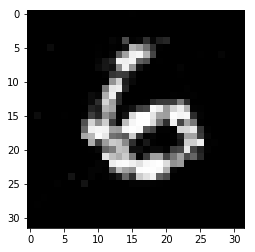

In [84]:
target = 6

label = tf.convert_to_tensor(ds._preprocess_labels(np.array([target])), dtype=tf.float32)
sample = generate(sample_latent_factors(1), label)[0]
print("Disc prob: {}".format(discriminate(tf.reshape(sample, (-1,32,32)), label).numpy()[0][0]))

plt.imshow(
    sample.numpy().reshape(32,32), 
    cmap='gray'
)

Lets generate a matrix of samples:
* Columns represent the label. Same column, same label.
* Rows represent the same latent factor (random noise). It is possible to see that there are different typographies.

In [146]:
labels = tf.convert_to_tensor(ds._preprocess_labels(range(ds.n_classes)), dtype=tf.float32)
noises = sample_latent_factors(30)

fig = plt.figure(figsize=(10,30))
axs = fig.subplots(len(noises), len(labels), gridspec_kw = {'wspace':0.1, 'hspace':0.2})

for i_label,label in enumerate(range(ds.n_classes)):
    for i_noise,noise in enumerate(noises):
        ax = axs[i_noise, i_label]
        ax.axis('off')
        ax.set_aspect('equal')
        ax.imshow(
            generate(noises[i_noise: i_noise+1], labels[i_label:i_label+1])[0].numpy().reshape(32,32),
            interpolation='nearest',
            cmap='gray'
        )

fig.savefig("img/cgan/matrix.png")
plt.close(fig)

![](img/cgan/matrix.png)

## References

1. <a name="bib-paper-cgans"></a>[Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784)
2. <a name="bib-web-cgan_infogan"></a>[GAN — CGAN & InfoGAN (using labels to improve GAN)](https://medium.com/@jonathan_hui/gan-cgan-infogan-using-labels-to-improve-gan-8ba4de5f9c3d)
3. <a name="bib-tf-dcan"></a>[DCGAN in Tensorflow](https://github.com/carpedm20/DCGAN-tensorflow)
4. <a name="bib-tf-gans"></a>[Conditional Generative Adversarial Nets in TensorFlow](https://wiseodd.github.io/techblog/2016/12/24/conditional-gan-tensorflow/)